In [11]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Load the CSV files
df_curated = pd.read_csv('train_curated.csv')
df_noisy = pd.read_csv('train_noisy.csv')
df_siren = pd.read_csv('siren.csv')
df_carhorn = pd.read_csv('car_horn.csv')
# Paths to the audio files
audio_path_curated = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_curated'
audio_path_noisy = '/Users/owo/HOUSE/@DUNE/@AI/Sound Classification2/freesound-audio-tagging-2019/train_noisy'

# Concatenate the DataFrames
df = pd.concat([df_curated,df_noisy,df_siren,df_carhorn], ignore_index=True)
df

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
...,...,...
26138,99812-1-2-0.wav,car_horn
26139,99812-1-3-0.wav,car_horn
26140,99812-1-4-0.wav,car_horn
26141,99812-1-5-0.wav,car_horn


In [41]:
import librosa
import warnings
import os
def drop_unloadable_files(df, audio_dir):
    # Iterate over the DataFrame
    for i, row in df.iterrows():
        audio_file = os.path.join(audio_dir, row['fname'])
        try:
            # Try to load the audio file
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                librosa.load(audio_file, sr=None)
        except Exception:
            # If loading fails, drop the row
            df = df.drop(i)
    return df

# Drop rows with unloadable audio files from the curated and noisy DataFrames
df_curated = drop_unloadable_files(df_curated, audio_path_curated)
df_noisy = drop_unloadable_files(df_noisy, audio_path_noisy)

# Concatenate the curated and noisy DataFrames
df_1 = pd.concat([df_curated, df_noisy,df_siren,df_carhorn], ignore_index=True)
df_1.to_csv('train_concat_drop.csv', index=False)
df_1

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping
...,...,...
24507,99812-1-2-0.wav,car_horn
24508,99812-1-3-0.wav,car_horn
24509,99812-1-4-0.wav,car_horn
24510,99812-1-5-0.wav,car_horn


In [42]:
## You can start from here
import pandas as pd

try:
    # Split the labels on the commas to create a list of labels for each sample
    df['labels'] = df_1['labels'].str.split(',')
except:
    df = pd.read_csv('train_concat_drop.csv')
    df['labels'] = df_1['labels'].str.split(',')
    print('load concat csv')
df

,fname,labels
0,0006ae4e.wav,[Bark]
1,0019ef41.wav,[Raindrop]
2,001ec0ad.wav,[Finger_snapping]
3,0026c7cb.wav,[Run]
4,0026f116.wav,[Finger_snapping]
...,...,...
24507,99812-1-2-0.wav,[car_horn]
24508,99812-1-3-0.wav,[car_horn]
24509,99812-1-4-0.wav,[car_horn]
24510,99812-1-5-0.wav,[car_horn]


(siren                              929
 car_horn                           429
 Bark                               354
 Car_passing_by                     352
 Bus                                351
 Traffic_noise_and_roadway_noise    351
 Shatter                            350
 Knock                              348
 Slam                               347
 Motorcycle                         346
 Yell                               346
 Screaming                          345
 Bicycle_bell                       336
 Name: labels, dtype: int64,
 <Axes: >)

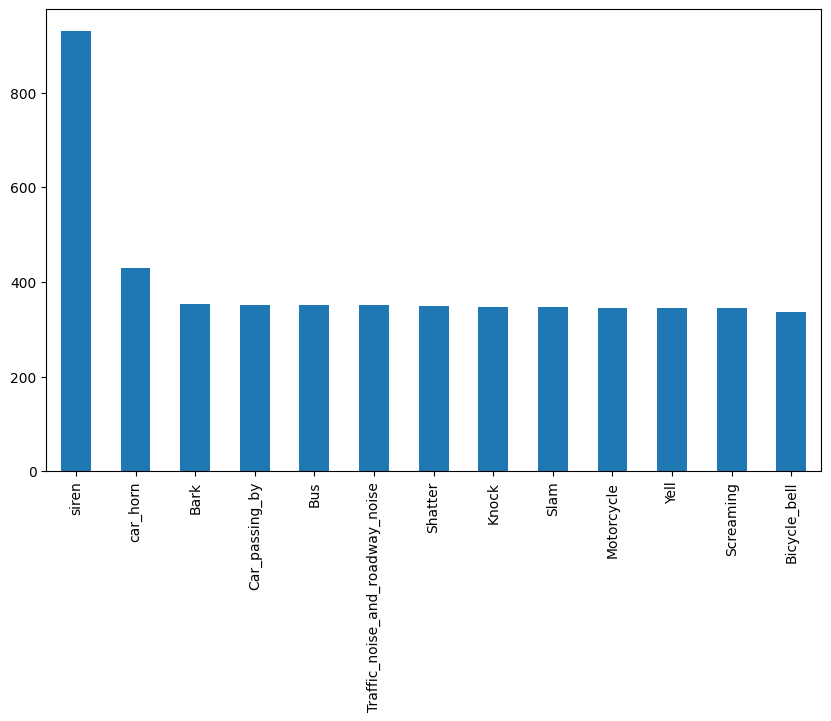

In [43]:
# Explode the DataFrame on the 'labels' column
df_exploded = df.explode('labels')

# Select the labels
selected_labels = ['Motorcycle', 'Slam', 'Yell', 'Screaming', 'Bus',
                   'Traffic_noise_and_roadway_noise', 'Car_passing_by',
                   'Bicycle_bell', 'Knock', 'Bark', 'Scream', 'Shatter','siren','car_horn']

# Filter the data
df_filtered = df_exploded[df_exploded['labels'].isin(selected_labels)]

# Count the number of occurrences of each label
label_counts = df_filtered['labels'].value_counts()

label_counts, label_counts.plot(kind='bar', figsize=(10, 6))


In [44]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Filter the dataframe to only include rows with the selected labels
df = df[df['labels'].apply(lambda x: any([label in x for label in selected_labels]))]

# Create a new DataFrame containing only the filtered labels
labels_df = df['labels'].apply(lambda x: [label for label in x if label in selected_labels])

# One-hot encode the labels
df = df.join(pd.DataFrame(mlb.fit_transform(labels_df),
                          columns=mlb.classes_,
                          index=df.index))

# Drop the 'labels' column
df = df.drop(columns=['labels'])

df

,fname,Bark,Bicycle_bell,Bus,Car_passing_by,Knock,Motorcycle,Screaming,Shatter,Slam,Traffic_noise_and_roadway_noise,Yell,car_horn,siren
0,0006ae4e.wav,1,0,0,0,0,0,0,0,0,0,0,0,0
14,00c40a6d.wav,0,0,0,0,1,0,0,0,0,0,0,0,0
15,00c4e82c.wav,0,0,0,0,0,1,0,0,0,0,0,0,0
23,015a50b9.wav,1,0,0,0,0,0,0,0,0,0,0,0,0
31,02286d70.wav,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24507,99812-1-2-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24508,99812-1-3-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24509,99812-1-4-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0
24510,99812-1-5-0.wav,0,0,0,0,0,0,0,0,0,0,0,1,0


In [45]:
len(mlb.classes_)

13

In [46]:
#Cut audio
import os
import numpy as np
import librosa

def load_audio(fname, sr=22050):
    # Paths to the audio files
    audio_path_curated = 'train_curated'  # Adjust these paths according to your directory structure
    audio_path_noisy = 'train_noisy'  # Adjust these paths according to your directory structure

    # Check if the file exists in the curated directory
    if os.path.exists(os.path.join(audio_path_curated, fname)):
        filename = os.path.join(audio_path_curated, fname)
    # Otherwise, check the noisy directory
    elif os.path.exists(os.path.join(audio_path_noisy, fname)):
        filename = os.path.join(audio_path_noisy, fname)
    else:
        raise FileNotFoundError(f"{fname} not found in both directories.")
    
    # Load the audio file
    y, _ = librosa.load(filename, sr=sr)
    
    return y


In [48]:
#  Augment audio
import random

def augment_audio(y, duration=2, sr=22050): #ducation = 2seconds
    # Apply time stretching
    rate = random.uniform(0.8, 1.2)  # Randomly vary the speed between 80% and 120%
    y = librosa.effects.time_stretch(y, rate = rate)

    ## Cut audio
    # If the audio is too short, pad it with zeros
    if len(y) < sr * duration:
        y = np.pad(y, (0, int(sr * duration) - len(y)))
    
    # If the audio is too long, randomly select a segment
    if len(y) > sr * duration:
        max_start_index = len(y) - int(sr * duration) #audio lengh - 2 seconds
        start_index = np.random.randint(0, max_start_index) # start anywhere except the last 2 seconds
        y = y[start_index:start_index + int(sr * duration)] # cut anywhere 2 seconds

    # Apply pitch shifting
    steps = random.randint(-3, 3)  # Randomly vary the pitch by up to 3 semitones
    y = librosa.effects.pitch_shift(y, sr = sr , n_steps= steps)

    # Apply additive noise
    noise = np.random.normal(0, 0.1, len(y))  # White noise with a standard deviation of 0.1
    y += noise
    


    return y

In [49]:
def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

In [50]:
spectrograms = []
labels = []

# Load, cut, augment, and get the spectrogram of each audio file 10 times
for i in range(len(df)):
    filename = df.iloc[i]['fname']
    label = df.iloc[i].drop('fname').values  # Get the label of the audio file

    # Load and cut the audio
    y = load_audio(filename)
    
    for _ in range(2):    
        # Augment the audio
        y_aug = augment_audio(y,duration=2)
        
        # Get the spectrogram of the augmented audio
        mel_spec = get_mel_spectrogram(y_aug)
        
        # Add the spectrogram to the list
        spectrograms.append(mel_spec)
        
        # Add the label to the list
        labels.append(label)


/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/owo/anaconda3/envs/torchenv/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [51]:
# Convert the list of spectrograms and labels to numpy arrays
spectrograms = np.array(spectrograms)
#labels = np.array(labels)

In [52]:
np.save('spectrograms.npy', spectrograms)
np.save('labels_aug.npy',labels)

In [53]:
# Load the spectrograms array from the .npy file
spectrograms_loaded = np.load('spectrograms.npy')
#labels = np.load('labels_aug.npy')

In [54]:
print(len(spectrograms_loaded),end=',')
print(len(spectrograms_loaded[0]),end=',')
print(len(spectrograms_loaded[0][0]))
print(len(labels),end=',')
print(len(labels[0]),end=',')

10122,128,87
10122,13,

In [55]:
#if use CNN type 1, if use resnet 18 type 2 , resnet 34 is type 3

select = 1
if select == 1:
    import torch
    import torch.nn as nn

    class AudioClassifier(nn.Module):
        def __init__(self):
            super(AudioClassifier, self).__init__()
            self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
            self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
            self.fc1 = nn.Linear(128*32*21, 1024)
            self.fc2 = nn.Linear(1024, len(mlb.classes_))

        def forward(self, x):
            x = x.unsqueeze(1)  # Add an extra dimension for the single channel
            x = torch.relu(self.conv1(x))
            x = torch.max_pool2d(x, 2)
            x = torch.relu(self.conv2(x))
            x = torch.max_pool2d(x, 2)
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x
if select == 2:
    import torch
    import torch.nn as nn
    from torchvision import models

    class AudioClassifier(nn.Module):
        def __init__(self, num_classes):
            super(AudioClassifier, self).__init__()
            self.resnet = models.resnet18(pretrained=True)
            
            # Modify first layer to take 1-channel input
            self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            
            # Modify last layer to have the correct number of output classes
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add an extra dimension for the single channel
            x = self.resnet(x)
            return x

    model = AudioClassifier(num_classes=len(mlb.classes_))
if select == 3:
    import torch
    import torch.nn as nn
    from torchvision import models

    class AudioClassifier(nn.Module):
        def __init__(self, num_classes):
            super(AudioClassifier, self).__init__()
            self.resnet = models.resnet34(pretrained=True)
            
            # Modify first layer to take 1-channel input
            self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            
            # Modify last layer to have the correct number of output classes
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add an extra dimension for the single channel
            x = self.resnet(x)
            return x

    model = AudioClassifier(num_classes=len(mlb.classes_))

In [56]:
from sklearn.model_selection import train_test_split

# Convert the spectrograms and labels to numpy arrays
X = np.array(spectrograms)
y = labels

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader

# Convert the training and validation sets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create PyTorch datasets from the tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create PyTorch dataloaders from the datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_9663/1144698830.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/torch/csrc/utils/tensor_new.cpp:248.)
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)


In [74]:
import torch
import time
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.nn import DataParallel
import platform
device = 'mps' if platform.system() == 'Darwin' else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the model, loss function and optimizer
model = AudioClassifier().to(device)
if torch.cuda.device_count() > 1:  # Check if multiple GPUs are available
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)
    
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())

# For storing losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 10
best_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        #print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Save the model if it's the best so far
    if val_loss < best_loss:
        torch.save(model.state_dict(), 'AI2.pth')
        best_loss = val_loss

    end_time = time.time()
    elapsed_time = end_time - start_time
    estimated_time = elapsed_time * (num_epochs - epoch - 1)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Elapsed Time: {elapsed_time:.2f}s, Estimated Time Left: {estimated_time:.2f}s")

print("Finished Training")

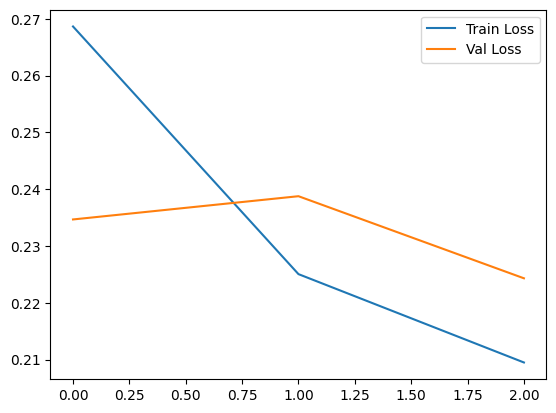

In [ ]:
# Plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
val_labels_list = []
val_preds_list = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        labels_np = labels.cpu().numpy()

        val_labels_list.extend(labels_np)
        val_preds_list.extend(predicted)

val_accuracy = accuracy_score(val_labels_list, val_preds_list)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.1842


In [73]:
import sounddevice as sd
import librosa
import numpy as np
import torch

def get_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Compute the spectrogram
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D_abs = np.abs(D)
    # Convert to Mel scale
    mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(D_abs), sr=sr, n_mels=n_mels)
    return mel_spec

# Load the trained model
model = AudioClassifier()

try:
    model.load_state_dict(torch.load('AI2.pth'))
except:
    try:
        model.load_state_dict(torch.load('AI2.pth', map_location=torch.device('cpu')))
    except:
        state_dict = torch.load('AI2.pth', map_location=torch.device('cpu'))
        new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
model.eval()

# Record audio
duration = 2  # seconds
fs = 44100  # Sample rate
recording = sd.rec(int(duration * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished

# Preprocess audio
recording = np.squeeze(recording)  # Remove the singleton dimension
recording = librosa.resample(recording, orig_sr=fs, target_sr=22050)  # Resample the recording
mel_spec = get_mel_spectrogram(recording)  # Compute the Mel spectrogram

# Make prediction
mel_spec = torch.from_numpy(mel_spec).unsqueeze(0).float()  # Add two singleton dimensions at the beginning
outputs = model(mel_spec)
probs = torch.nn.functional.softmax(outputs, dim=1)
top_prob, top_label = torch.max(probs, dim=1)

#print(f"Predicted label: {le.inverse_transform([top_label.item()])[0]}")
#print(f"Probability: {top_prob.item() * 100:.2f}%")
# Define the threshold
threshold = 0.0

# Apply threshold to probabilities
high_prob_mask = probs > threshold


# Convert probabilities tensor to numpy array
probs_array = probs.detach().numpy()

# Iterate over all labels and their corresponding probabilities
for label, prob in zip(mlb.classes_, probs_array[0]):
    print(f"Label: {label}, Probability: {prob * 100:.2f}%")

# Get labels for high-probability predictions

#high_prob_labels = le.inverse_transform(torch.where(high_prob_mask)[1])
# Get probabilities for high-confidence predictions
high_prob_probs = probs[high_prob_mask]

# Get labels for high-confidence predictions
high_prob_labels = mlb.inverse_transform(high_prob_mask.numpy())

# Convert high_prob_labels and high_prob_probs to lists
high_prob_labels = high_prob_labels[0]
high_prob_probs = high_prob_probs.tolist()

# Print labels and corresponding probabilities
for label, prob in zip(high_prob_labels, high_prob_probs):
    print(f"Predicted label: {label}, Probability: {prob * 100:.2f}%")


print(f"Predicted labels: {high_prob_labels}")


Predicted label: siren, Probability: 100.00%
Predicted labels: ('siren',)


# Diary
2023.07.24 0109i

I honestly spent like 15 hours to make this today. It took a lot of time but since I did 'urban 8 sound' before. It was slightly OK but still frustrating. I was almost done finishing this project then I noticed that some of the label has MORE than one label at a time. Then I have to do this whole thing over again . That was my first drag, and the second drag was at the fact I accidentally deleted the whole thing pressing undo in GitHub. Thankfully I had all the things in chat GPT, so that from there I was easily recovered.  
I still have a problem with real time analizer but I can sort it out later  
I have to go to work tommorrow, I have to go to sleep.  


2023.07.25 1555i
